# МО для металлургического комбината

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

**Цель проекта**: разработать модель машинного обучения, которая будет предсказывать температуру сплава. Метрика качества MAE должна быть не больше 6.8.

Заказчик будет использовать разработанную модель для имитации технологического процесса.

In [1]:
!pip install shap 
!pip install phik
!pip install scikit-learn==0.24.1
!pip install matplotlib==3.3.4
!pip install numpy==1.20.1
!pip install pandas==1.2.4
!pip install scikit-learn==0.24.1
!pip install seaborn==0.11.1
!pip install catboost==1.0.3
!pip install transformers==4.12.5 

import sklearn
sklearn.__version__

  Using cached scikit-learn-0.24.1.tar.gz (7.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for scikit-learn (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1662 lines of output]
      <string>:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      Partial import of sklearn during the build process.
      <string>:116: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.ht

'1.5.0'

In [2]:
# загружаю все нужные для проекта библиотеки

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mp
import sys
import numpy as np
import phik
import shap
from sklearn.dummy import DummyRegressor


from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score



/Users/ira-bobrineva/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
def load_data(pth1, pth2): # загрузка данных
    if os.path.exists(pth1):
        data = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        data = pd.read_csv(pth2)
    else:
        print('Что-то не так')
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    print(data.head())
    data.info()
    print(data.describe())
    return data

def plot_data(data, plot_type, title, xlabel, rows_amount, columns_amount): # построение графиков
    data_without_key = data.drop('key', axis=1)
    fig, axs = plt.subplots(rows_amount, columns_amount, figsize=(15, 10))
    axs = axs.ravel()

    for i, column in enumerate(data_without_key.columns):
        getattr(axs[i], plot_type)(data_without_key[column])
        axs[i].set_title(f'{title}: {column}')
        axs[i].set_xlabel(xlabel)
    
    plt.tight_layout()
    plt.show()


## Загрузка и изучение данных

In [4]:
data_electrodes = load_data('/Users/ira-bobrineva/Downloads/data_arc_new.csv', '/datasets/data_arc_new.csv')

   key начало_нагрева_дугой  конец_нагрева_дугой  активная_мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   реактивная_мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реак

In [5]:
for n in ('начало_нагрева_дугой', 'конец_нагрева_дугой'): # поправила тип данных
    data_electrodes[n] = data_electrodes[n].astype('datetime64[ns]')
data_electrodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


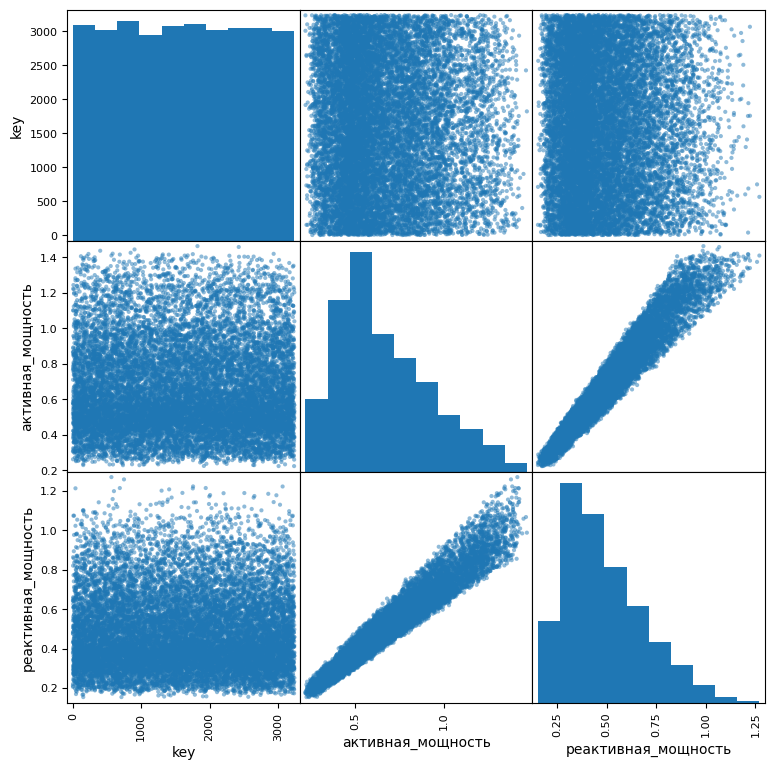

In [6]:
data_electrodes = data_electrodes.loc[data_electrodes['реактивная_мощность'] != -715.479924] # удалила отрицательное значение, потому что из-за него график выходил неверным
pd.plotting.scatter_matrix(data_electrodes, figsize=(9, 9))
plt.show()

В данных по нагреву электродами было одно отрицательное значение мощности. Убрала его. По графику видна линейная зависимость активной мощности и реактивной: чем больше активная мощность, тем выше и реактивная.

In [7]:
data_bulk_amount = load_data('/Users/ira-bobrineva/Downloads/data_bulk_new.csv', '/datasets/data_bulk_new.csv')

   key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   

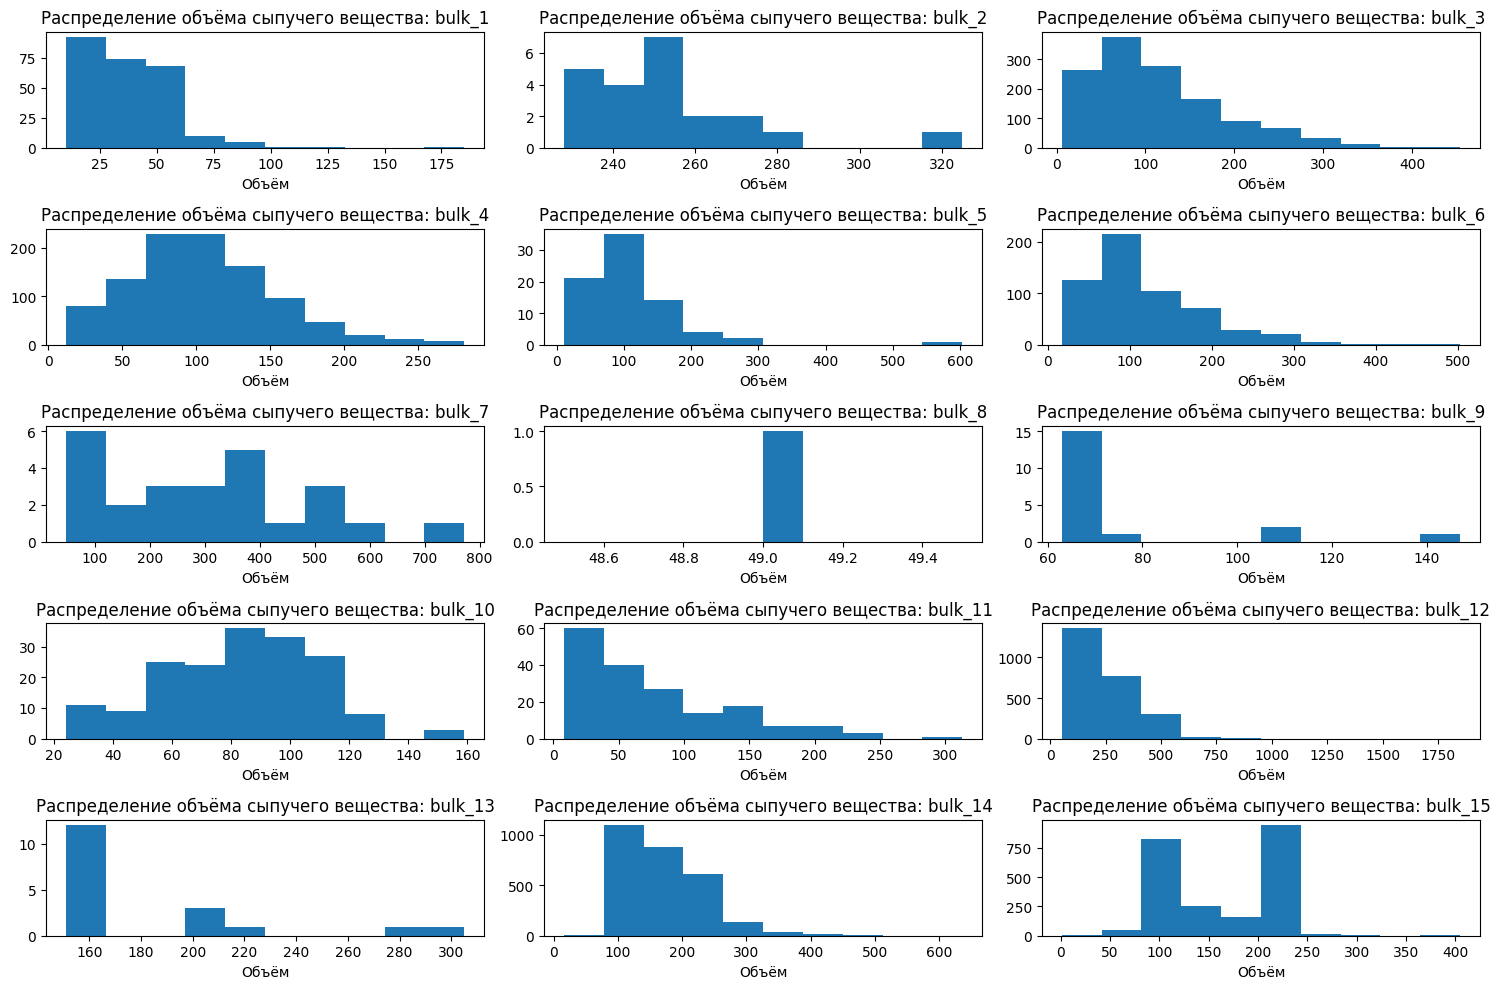

In [8]:
plot_data(data_bulk_amount, 'hist', 'Распределение объёма сыпучего вещества', 'Объём', 5, 3)

In [9]:
data_bulk_amount.isna().mean() * 100


key         0.000000
bulk_1     91.946309
bulk_2     99.296900
bulk_3     58.517098
bulk_4     67.593480
bulk_5     97.539150
bulk_6     81.591563
bulk_7     99.201023
bulk_8     99.968041
bulk_9     99.392777
bulk_10    94.375200
bulk_11    94.343241
bulk_12    21.700224
bulk_13    99.424736
bulk_14    10.322787
bulk_15    28.155960
dtype: float64

В данных по сыпучим материалам много пропусков, их нужно будет обработать. Эти материалы добавлялись не в каждой итерации

In [10]:
data_bulk_time = load_data('/Users/ira-bobrineva/Downloads/data_bulk_time_new.csv', '/datasets/data_bulk_time_new.csv')

   key bulk_1 bulk_2 bulk_3               bulk_4 bulk_5 bulk_6 bulk_7 bulk_8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  bulk_9 bulk_10 bulk_11              bulk_12 bulk_13              bulk_14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               bulk_15  
0  2019-05-03 11:10:43  


In [11]:
for n in ('bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'):
    data_bulk_time[n] = data_bulk_time[n].astype('datetime64[ns]') # тут тоже поправила тип данных
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.3 KB


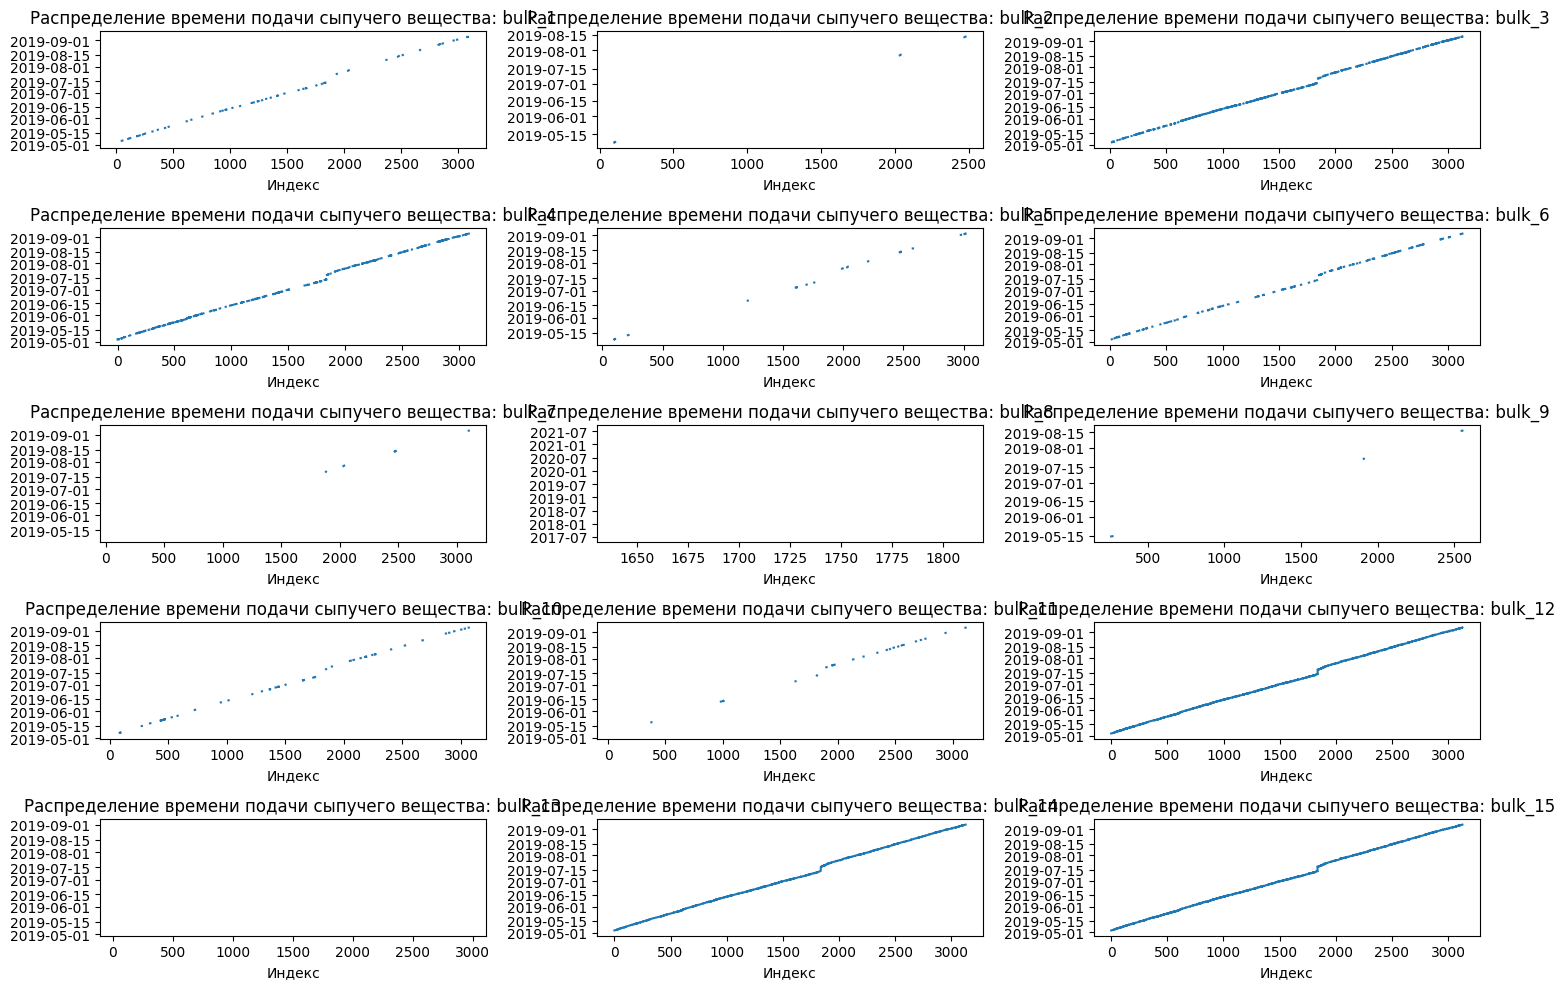

In [12]:
plot_data(data_bulk_time, 'plot', 'Распределение времени подачи сыпучего вещества', 'Индекс', 5, 3)

Распределение данных по времени подачи сыпучих материалов соотносится с распределение объёмов этих материалов: чем меньше использовались добавки, тем меньше точек на графике времени

In [13]:
pth1 = '/Users/ira-bobrineva/Downloads/data_gas_new.csv'
pth2 = '/datasets/data_gas_new.csv'
if os.path.exists(pth1):
    data_gas_amount = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_gas_amount = pd.read_csv(pth2)
else:
    print('Что-то не так')
data_gas_amount.columns = data_gas_amount.columns.str.lower().str.replace(' ', '_')
print(data_gas_amount.head())
print(data_gas_amount.info())
print(data_gas_amount.describe())
   

   key      газ_1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
               key        газ_1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


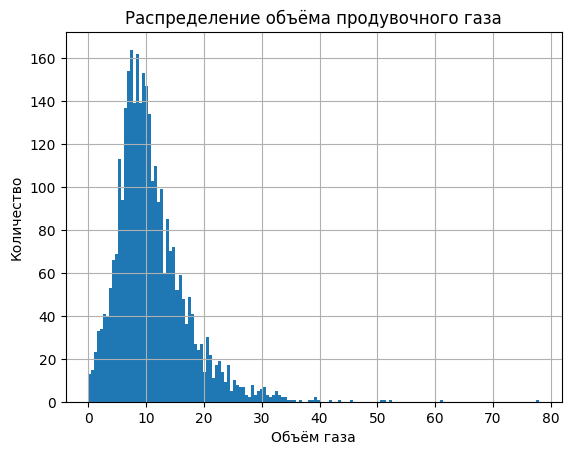

In [14]:
data_gas_amount_without_key = data_gas_amount.drop('key', axis=1)
data_gas_amount_without_key.hist(bins=150)
plt.title('Распределение объёма продувочного газа')
plt.ylabel('Количество')
plt.xlabel('Объём газа')
plt.show()

Сплав продувался газом в каждой итерации, пропусков значений в данных нет и самое низкое значение объёма не нулевое

In [15]:
data_temp = load_data('/Users/ira-bobrineva/Downloads/data_temp_new.csv', '/datasets/data_temp_new.csv')

   key         время_замера  температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   время_замера  18092 non-null  object 
 2   температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
                key   температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000


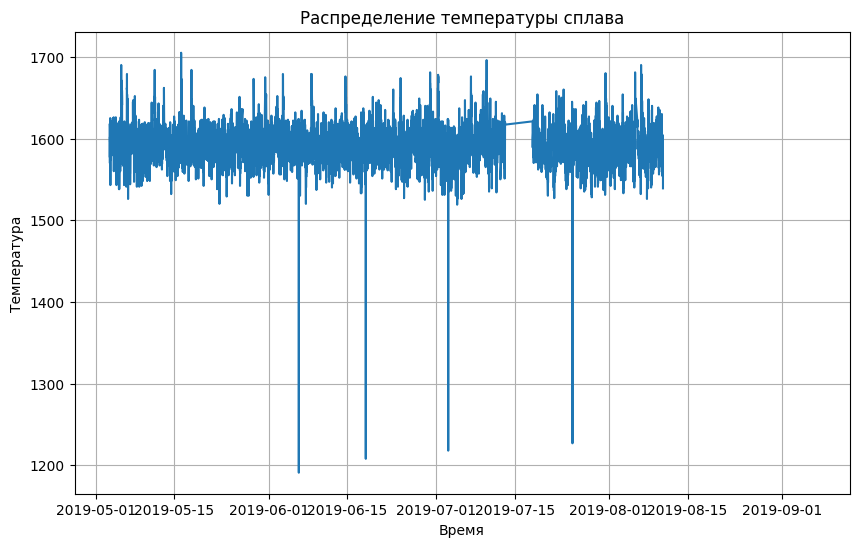

In [16]:
data_temp['время_замера'] = data_temp['время_замера'].astype('datetime64[ns]')
plt.figure(figsize=(10, 6))
plt.plot(data_temp['время_замера'], data_temp['температура'])
plt.xlabel('Время')
plt.ylabel('Температура')
plt.title('Распределение температуры сплава')
plt.grid(True)
plt.show()

В данных по температуре есть значения ниже 1500 и ключи с одним замером температуры за всю итерацию. Такие значения нужно будет убрать

In [17]:
data_wire_amount = load_data('/Users/ira-bobrineva/Downloads/data_wire_new.csv', '/datasets/data_wire_new.csv')

   key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non

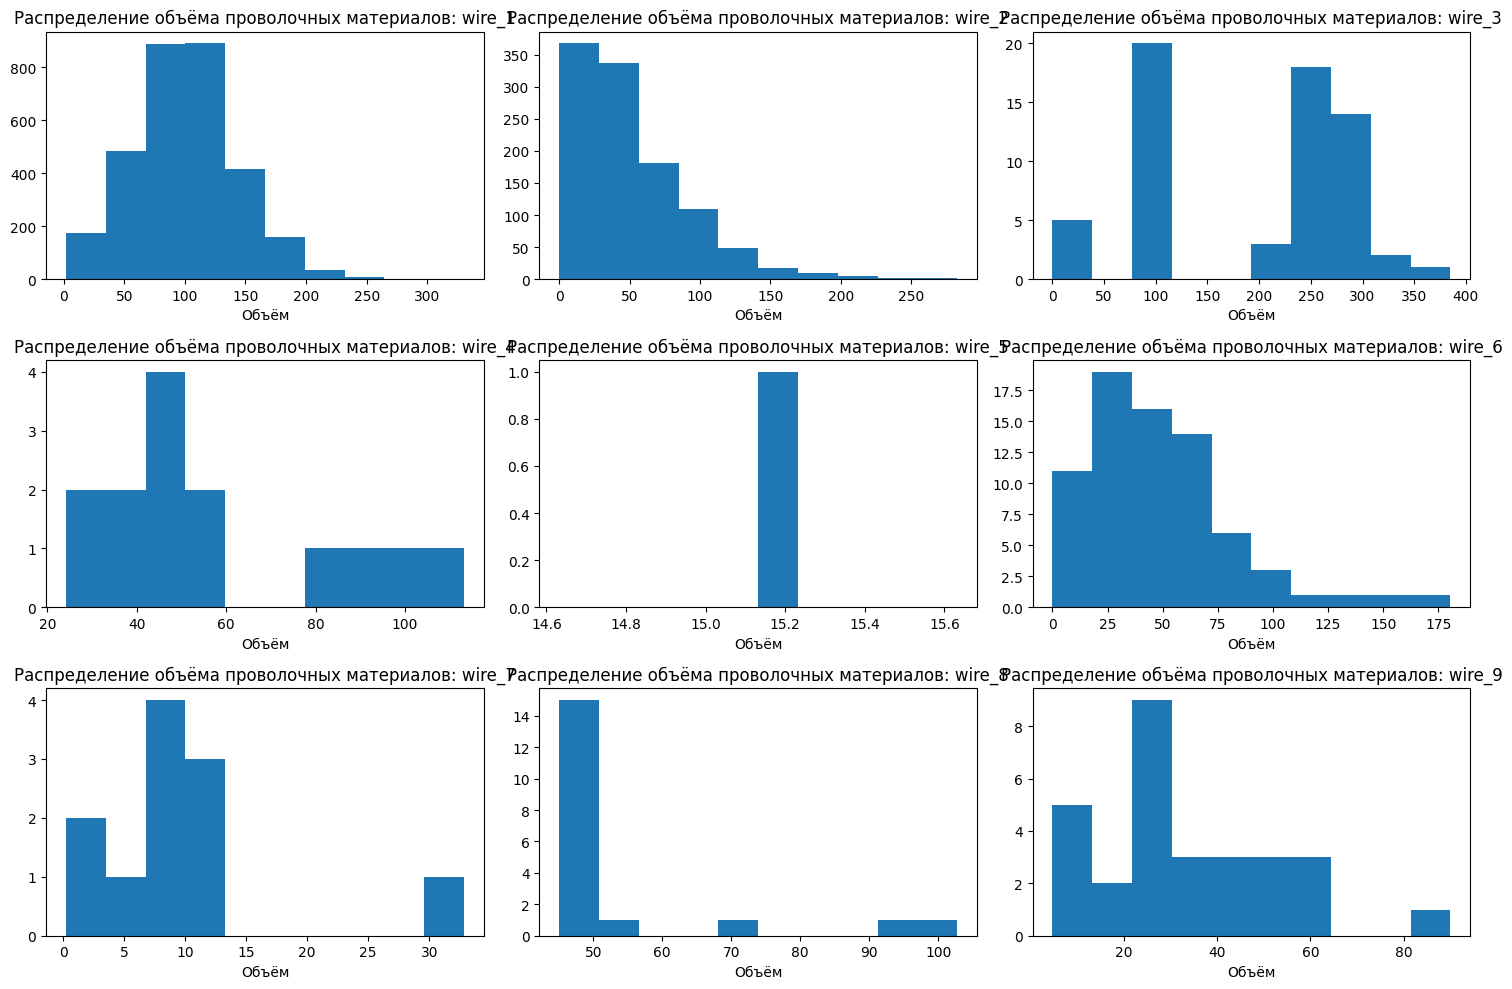

In [18]:
plot_data(data_wire_amount, 'hist', 'Распределение объёма проволочных материалов', 'Объём', 3, 3)

In [19]:
data_wire_amount.isna().mean() * 100

key        0.000000
wire_1     0.843882
wire_2    64.978903
wire_3    97.955209
wire_4    99.545602
wire_5    99.967543
wire_6    97.630639
wire_7    99.642973
wire_8    99.383317
wire_9    99.058747
dtype: float64

В проволочных материалах также есть много пропусков: эти материалы добавлялись не в каждой итерации. Пропуски нужно будет обработать

In [20]:
data_wire_time = load_data('/Users/ira-bobrineva/Downloads/data_wire_time_new.csv', '/datasets/data_wire_time_new.csv')

   key               wire_1               wire_2 wire_3 wire_4 wire_5 wire_6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  wire_7 wire_8 wire_9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_

In [21]:
for n in ('wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'):
    data_wire_time[n] = data_wire_time[n].astype('datetime64[ns]') # тут тоже правлю тип данных
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


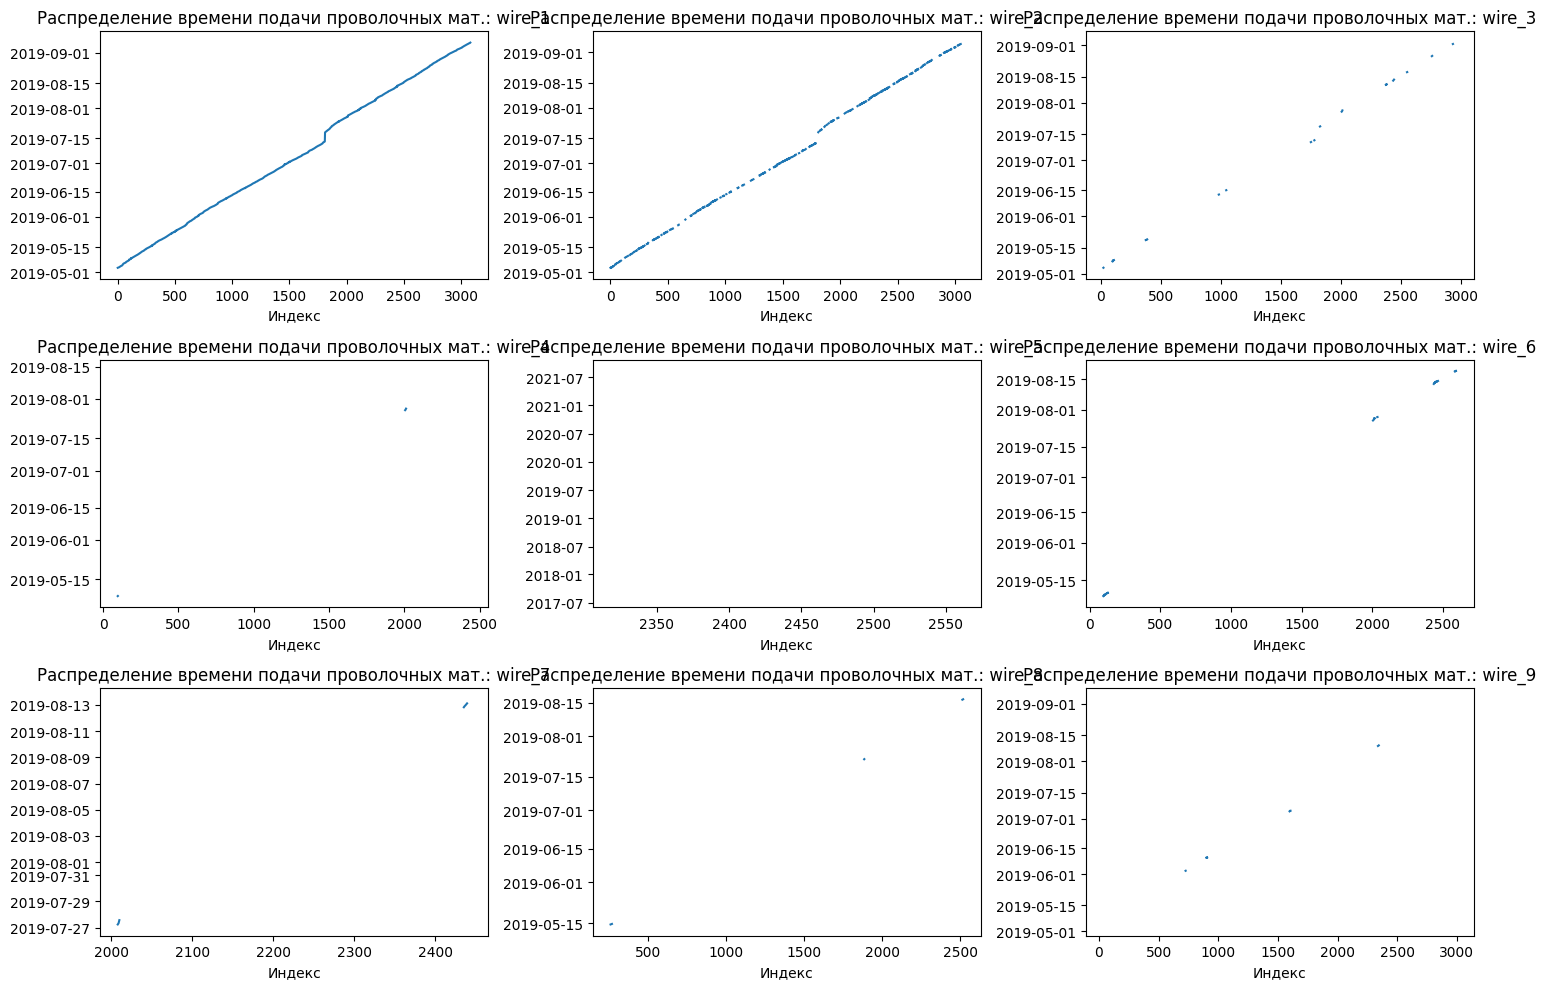

In [22]:
plot_data(data_wire_time, 'plot', 'Распределение времени подачи проволочных мат.', 'Индекс', 3, 3)

Данные по распределению времени подачи проволочных материалов соотносятся с объёмами подачи: чем меньше точек на графике времени, тем меньше проволочных материалов подали. 

### Общий вывод по первичному изучению данных

* В данных по нагреву электродами был выброс - одно отрицательное значение мощности, которое нужно было удалить.
* В данных по сыпучим и проволочным материалам много пропусков, их нужно будет обработать: заменить на нули. Проверка на долю пропущенных значений поможет отобрать важные признаки.
* Время подачи сыпучих и проволочных материалов соотносится с распределением объёма этих материалов.
* Сплав продувался газом в каждой итерации, пропусков значений в данных нет, поэтому эти данные дополнительно обрабатывать не нужно будет.
* В данных по температуре есть значения ниже 1500 и ключи с одним замером температуры за всю итерацию. Такие значения нужно будет убрать.


## Предобработка данных

### data_electrodes

В данных по электродам надо:
   * удалить строчки с отрицательными значениями в мощностях,
   * просуммировать данные по ключу.

In [23]:
data_electrodes_negative = data_electrodes.query('реактивная_мощность < 0 and активная_мощность < 0')
data_electrodes_negative

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность


Одно отрицательное значение было только в столбце 'реактивная мощность'.

In [24]:
# выведу просуммированные активную и реактивную мощности
data_electrodes_agg = data_electrodes.pivot_table(index='key', values=['активная_мощность', 'реактивная_мощность'], aggfunc='sum')
# добавлю новый признак - длительность нагрева ковша
data_electrodes_agg['длительность_нагрева_секунды'] = (data_electrodes['конец_нагрева_дугой'] - data_electrodes['начало_нагрева_дугой']).dt.total_seconds()
data_electrodes_agg

,активная_мощность,реактивная_мощность,длительность_нагрева_секунды
key,,,
1,3.036730,2.142821,185.0
2,2.139408,1.453357,172.0
3,4.063641,2.937457,365.0
4,2.706489,2.056992,148.0
5,2.252950,1.687991,137.0
...,...,...,...
3237,2.541872,2.025417,332.0
3238,1.374821,1.038103,53.0
3239,4.848005,3.541541,182.0


Просуммировала значения активной и реактивной мощностей по ключу и нашла длительность нагрева ковша.

### data_bulk_amount

В данных есть много пропусков, заполню их нулями.

In [25]:
data_bulk_amount = data_bulk_amount.fillna(0)
data_bulk_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


### data_temp

Удалю значения температуры, которые ниже 1500, и ключи с одним замером температуры

In [26]:
# нашла значения ключей, где температура ниже 1500 или пустое значение
# ключи с пустым значением температуры замерялись только один раз
data_temp_keys = data_temp[(data_temp['температура'] < 1500) | (data_temp['температура'].isna())]
unique_keys = data_temp_keys['key'].unique()
unique_keys

array([ 867, 1214, 1619, 2052, 2500, 2501, 2502, 2503, 2504, 2505, 2506,
       2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517,
       2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528,
       2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539,
       2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550,
       2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561,
       2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572,
       2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583,
       2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594,
       2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605,
       2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616,
       2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627,
       2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638,
       2639, 2640, 2641, 2642, 2643, 2644, 2645, 26

In [27]:
data_temp = data_temp[~data_temp['key'].isin(unique_keys)].copy() # убрала ключи с температурой ниже 1500 и с одним замером
data_temp


,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [28]:
# создам таблицу с признаком и таргетом: первой и последней температурой ковша
# ещё добавлю столбцы с временем замера первой и последней температур, эти столбцы понадобятся, чтобы создать доп признак - разницу замера температур

data_temp.loc[:, 'первая_температура'] = data_temp.groupby('key')['температура'].transform('first')
data_temp.loc[:, 'последняя_температура'] = data_temp.groupby('key')['температура'].transform('last')
data_temp.loc[:, 'замер_первой_температуры'] = data_temp.groupby('key')['время_замера'].transform('first')
data_temp.loc[:, 'замер_последней_температуры'] = data_temp.groupby('key')['время_замера'].transform('last')

data_temp_new = data_temp.drop_duplicates(subset='key', keep='first')[['key', 'замер_первой_температуры','замер_последней_температуры', 'первая_температура', 'последняя_температура']].reset_index(drop=True)
data_temp_new.head(10)

,key,замер_первой_температуры,замер_последней_температуры,первая_температура,последняя_температура
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
5,6,2019-05-03 13:46:41,2019-05-03 14:11:38,1543.0,1596.0
6,7,2019-05-03 14:16:36,2019-05-03 14:45:40,1586.0,1599.0
7,8,2019-05-03 14:53:46,2019-05-03 15:20:41,1577.0,1598.0
8,9,2019-05-03 15:36:33,2019-05-03 16:06:44,1587.0,1592.0
9,10,2019-05-03 16:13:59,2019-05-03 16:39:50,1574.0,1593.0


## data_temp_new.describe()

### data_wire_amount

Заполню пустые значения нулями.

In [29]:
data_wire_amount = data_wire_amount.fillna(0)
data_wire_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


## Объединение таблиц и отбор признаков

In [30]:
data = data_electrodes_agg.merge(data_bulk_amount, on='key', how='inner')
data = data.merge(data_temp_new, on='key', how='inner')
data = data.merge(data_wire_amount, on='key', how='inner')
data = data.merge(data_gas_amount, on='key', how='inner')
len(data['key'].unique())

2325

In [31]:
data.describe()

,key,активная_мощность,реактивная_мощность,длительность_нагрева_секунды,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,газ_1
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,...,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,3.125813,2.300941,175.957419,3.433548,1.424946,47.296774,37.331613,2.644731,22.468817,...,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658,11.378942
min,1.000000,0.267676,0.196228,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008399
25%,629.000000,2.295820,1.670519,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.282948
50%,1255.000000,3.036303,2.225398,152.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10.100950
75%,1868.000000,3.834300,2.829159,221.000000,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,...,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,14.217691
max,2499.000000,12.375636,8.949049,685.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,...,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,77.995040
std,715.099053,1.220473,0.903664,98.995029,12.421994,19.098442,75.228262,58.670377,22.421296,55.831097,...,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510,6.395632


In [32]:
data.tail()

,key,активная_мощность,реактивная_мощность,длительность_нагрева_секунды,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,газ_1
2320,2495,3.168133,2.210936,272.0,0.0,0.0,21.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2321,2496,4.174918,2.872031,187.0,0.0,0.0,0.0,63.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2322,2497,3.605239,2.452092,171.0,0.0,0.0,0.0,85.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2323,2498,3.202310,2.239820,98.0,0.0,0.0,90.0,0.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657
2324,2499,1.737084,1.296836,226.0,0.0,0.0,47.0,0.0,0.0,0.0,...,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.336151


In [33]:
# добавлю признак 'разница между замерами первой и последней температур'

data['разница_замера_температур'] = (data['замер_последней_температуры'] - data['замер_первой_температуры']).dt.total_seconds()

# добавлю признак 'полная мощность'
data['полная_мощность'] = np.sqrt(data['активная_мощность']**2 + data['реактивная_мощность']**2)

# уберу 'начало_нагрева_дугой', 'конец_нагрева_дугой', 'key', важность остальных признаков проверю с помощью графика важности признаков

data = data.drop(['активная_мощность', 'реактивная_мощность', 'замер_первой_температуры', 'замер_последней_температуры', 'bulk_8', 'bulk_9', 'bulk_13', 'wire_5', 'wire_8', 'wire_9'], axis=1)

data.head()

,key,длительность_нагрева_секунды,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_10,...,последняя_температура,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,газ_1,разница_замера_температур,полная_мощность
0,1,185.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,29.749986,1714.0,3.716640
1,2,172.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,12.555561,1265.0,2.586371
2,3,365.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,28.554793,1753.0,5.014163
3,4,148.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,18.841219,1220.0,3.399456
4,5,137.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,5.413692,1536.0,2.815155


Я не удалила все признаки, в которых нулевых значений больше 80%. Если удалить все такие признаки, то падает значение метрики. Дропнула признаки с наименьшей значимостью по шап-графику и с наибольшим количеством пропусков.

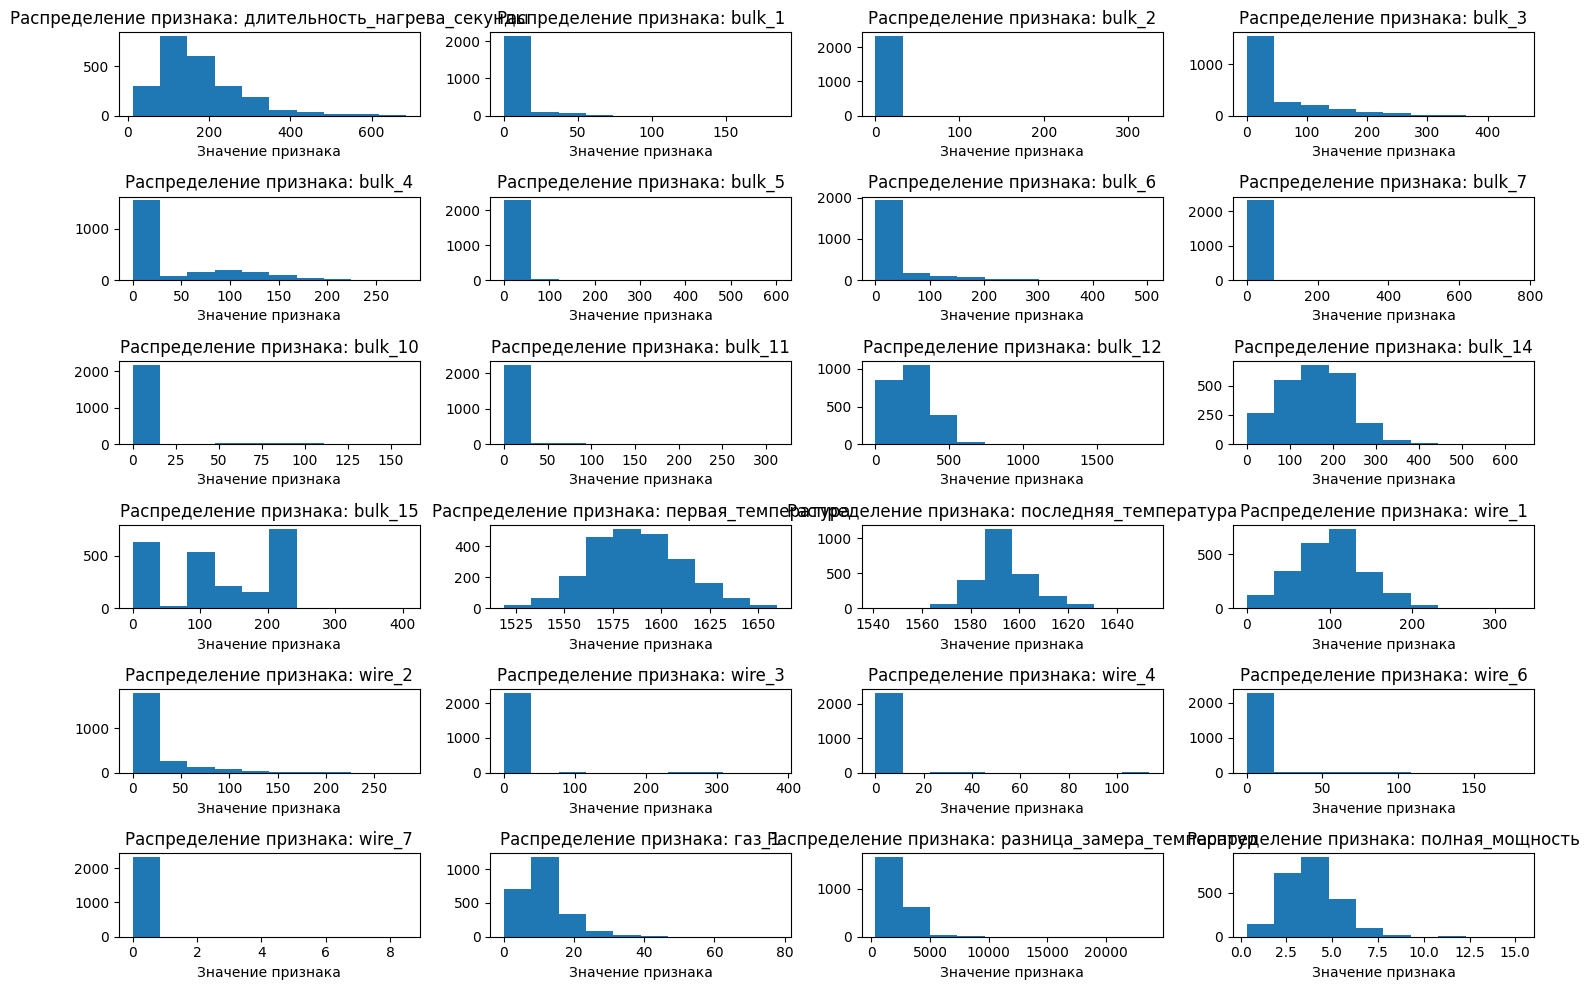

In [34]:
plot_data(data, 'hist', 'Распределение признака', 'Значение признака', 6, 4)

В целом все значения представлены без выбросов, только в bulk_10 есть немного выбивающихся значений. В объёмах добавок всё ещё видно большое количество пустых значений, но удалять их не буду, потому что даже небольшое количества значений важны для МО.

## Корреляционный анализ

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   key                           2325 non-null   int64  
 1   длительность_нагрева_секунды  2325 non-null   float64
 2   bulk_1                        2325 non-null   float64
 3   bulk_2                        2325 non-null   float64
 4   bulk_3                        2325 non-null   float64
 5   bulk_4                        2325 non-null   float64
 6   bulk_5                        2325 non-null   float64
 7   bulk_6                        2325 non-null   float64
 8   bulk_7                        2325 non-null   float64
 9   bulk_10                       2325 non-null   float64
 10  bulk_11                       2325 non-null   float64
 11  bulk_12                       2325 non-null   float64
 12  bulk_14                       2325 non-null   float64
 13  bul

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/Users/ira-bobrineva/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ira-bobrineva/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ira-bobrineva/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ira-bobrineva/anaconda3/lib/python3.11/sit

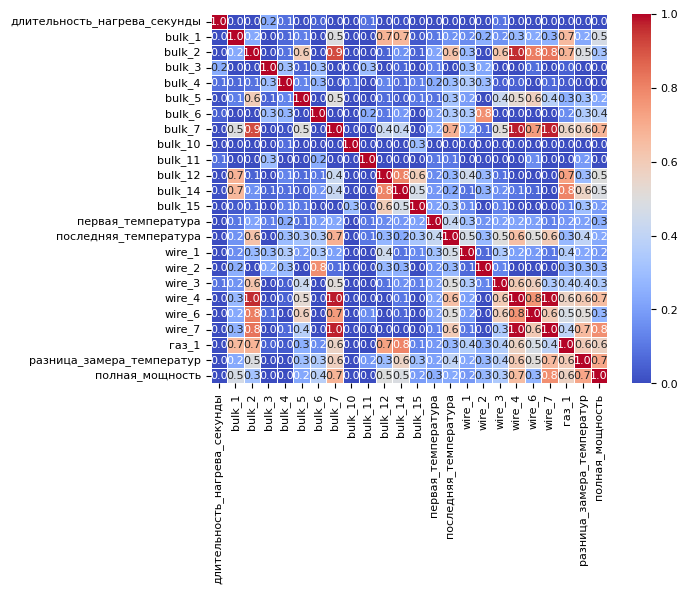

In [36]:
data = data.drop('key', axis=1)
phik_matrix = data.phik_matrix(interval_cols = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'первая_температура', 'последняя_температура', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'газ_1', 'длительность_нагрева_секунды', 'разница_замера_температур', 'полная_мощность'])
plt.rcParams['font.size'] = '8'
sns.heatmap(phik_matrix, annot=True, linewidth=.5, fmt=".1f", cmap='coolwarm')
plt.show()

Между признаками есть мультиколлинеарность, но убирать я её не буду. Я использую устойчивые к мультиколлинеарности модели - древесные и бустинговые.

## Пайплайн для моделей

Масштабировала признаки перед обучением модели, даже если это не требуется для древесных и бустинговых моделей. Это всё-таки немного помогает с качеством метрики.

In [37]:
RANDOM_STATE = 200524
TEST_SIZE = 0.25

X = data.drop(['последняя_температура'], axis=1)
y = data['последняя_температура']


num_columns = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'первая_температура', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'газ_1', 'длительность_нагрева_секунды', 'разница_замера_температур', 'полная_мощность']

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

param_distributions = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 100),
        'models__min_samples_split': range(2, 100),
        'models__min_samples_leaf': range(1, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(50, 500),
        'models__max_depth': range(1, 16),
        'models__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'preprocessor__num': [StandardScaler(), 'passthrough']

    },
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(50, 500),
        'models__max_depth': range(1, 20),
        'models__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=200,
    error_score='raise'
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f"Число строк в тренировочной выборке: {X_train.shape[0]}")

Число строк в тренировочной выборке: 1743


In [38]:
randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_

best_model

0:	learn: 11.1089964	total: 63.6ms	remaining: 20.5s
1:	learn: 11.0333217	total: 64.1ms	remaining: 10.3s
2:	learn: 10.9643363	total: 64.6ms	remaining: 6.91s
3:	learn: 10.9016025	total: 65.1ms	remaining: 5.21s
4:	learn: 10.8406562	total: 65.6ms	remaining: 4.18s
5:	learn: 10.7752586	total: 66ms	remaining: 3.5s
6:	learn: 10.7045884	total: 66.5ms	remaining: 3.01s
7:	learn: 10.6365660	total: 67ms	remaining: 2.65s
8:	learn: 10.5818335	total: 67.5ms	remaining: 2.36s
9:	learn: 10.5287676	total: 68ms	remaining: 2.13s
10:	learn: 10.4950115	total: 68.5ms	remaining: 1.95s
11:	learn: 10.4542019	total: 69ms	remaining: 1.79s
12:	learn: 10.4058233	total: 69.4ms	remaining: 1.66s
13:	learn: 10.3634155	total: 69.9ms	remaining: 1.55s
14:	learn: 10.3153118	total: 70.4ms	remaining: 1.45s
15:	learn: 10.2723713	total: 70.9ms	remaining: 1.36s
16:	learn: 10.2357265	total: 71.4ms	remaining: 1.29s
17:	learn: 10.1984451	total: 71.9ms	remaining: 1.22s
18:	learn: 10.1623784	total: 72.4ms	remaining: 1.16s
19:	learn: 1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bulk_1', 'bulk_2', 'bulk_3',
                                                   'bulk_4', 'bulk_5', 'bulk_6',
                                                   'bulk_7', 'bulk_10',
                                                   'bulk_11', 'bulk_12',
                                                   'bulk_14', 'bulk_15',
                                                   'первая_температура',
                                                   'wire_1', 'wire_2', 'wire_3',
                                                   'wire_4', 'wire_6', 'wire_7',
                                                   'газ_1',
                                                   'длительность_нагрева_секунды',
                                                   'разница_замера_температур',
                                                   'полная_мощность'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x28ae074d0>)])

In [39]:
best_score = randomized_search.best_score_
best_score

-6.973796588822482

In [40]:
result = pd.DataFrame(randomized_search.cv_results_)
print(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score'))

pd.set_option('display.max_colwidth', 10000)

     rank_test_score                                       param_models  \
61                 1  <catboost.core.CatBoostRegressor object at 0x2...   
62                 2  <catboost.core.CatBoostRegressor object at 0x2...   
25                 3                 LGBMRegressor(random_state=200524)   
45                 4  <catboost.core.CatBoostRegressor object at 0x2...   
54                 5                 LGBMRegressor(random_state=200524)   
..               ...                                                ...   
149              193         DecisionTreeRegressor(random_state=200524)   
187              197         DecisionTreeRegressor(random_state=200524)   
182              198         DecisionTreeRegressor(random_state=200524)   
83               199         DecisionTreeRegressor(random_state=200524)   
57               200         DecisionTreeRegressor(random_state=200524)   

     mean_test_score                                             params  
61         -6.973797  {'p

Лучшая модель - CatBoostRegressor. Она показывает на тренировочной выборке 6.97 MAE. Параметры модели: 'preprocessor__num': StandardScaler(), 'models__n_estimators': 324, 'models__max_depth': 3, 'models__learning_rate': 0.05.

## Анализ важности признаков

0:	learn: 11.2107872	total: 1.14ms	remaining: 370ms
1:	learn: 11.1425290	total: 1.79ms	remaining: 289ms
2:	learn: 11.0608442	total: 2.21ms	remaining: 237ms
3:	learn: 10.9802516	total: 2.51ms	remaining: 201ms
4:	learn: 10.9124048	total: 2.8ms	remaining: 178ms
5:	learn: 10.8471684	total: 3.13ms	remaining: 166ms
6:	learn: 10.7837934	total: 3.56ms	remaining: 161ms
7:	learn: 10.7333012	total: 3.89ms	remaining: 154ms
8:	learn: 10.6748003	total: 4.19ms	remaining: 147ms
9:	learn: 10.6285944	total: 4.49ms	remaining: 141ms
10:	learn: 10.5737953	total: 4.79ms	remaining: 136ms
11:	learn: 10.5235549	total: 5.09ms	remaining: 132ms
12:	learn: 10.4745444	total: 5.48ms	remaining: 131ms
13:	learn: 10.4302953	total: 5.86ms	remaining: 130ms
14:	learn: 10.3797162	total: 6.19ms	remaining: 128ms
15:	learn: 10.3450123	total: 6.5ms	remaining: 125ms
16:	learn: 10.3038869	total: 6.82ms	remaining: 123ms
17:	learn: 10.2646602	total: 7.18ms	remaining: 122ms
18:	learn: 10.2246065	total: 7.49ms	remaining: 120ms
19:	l

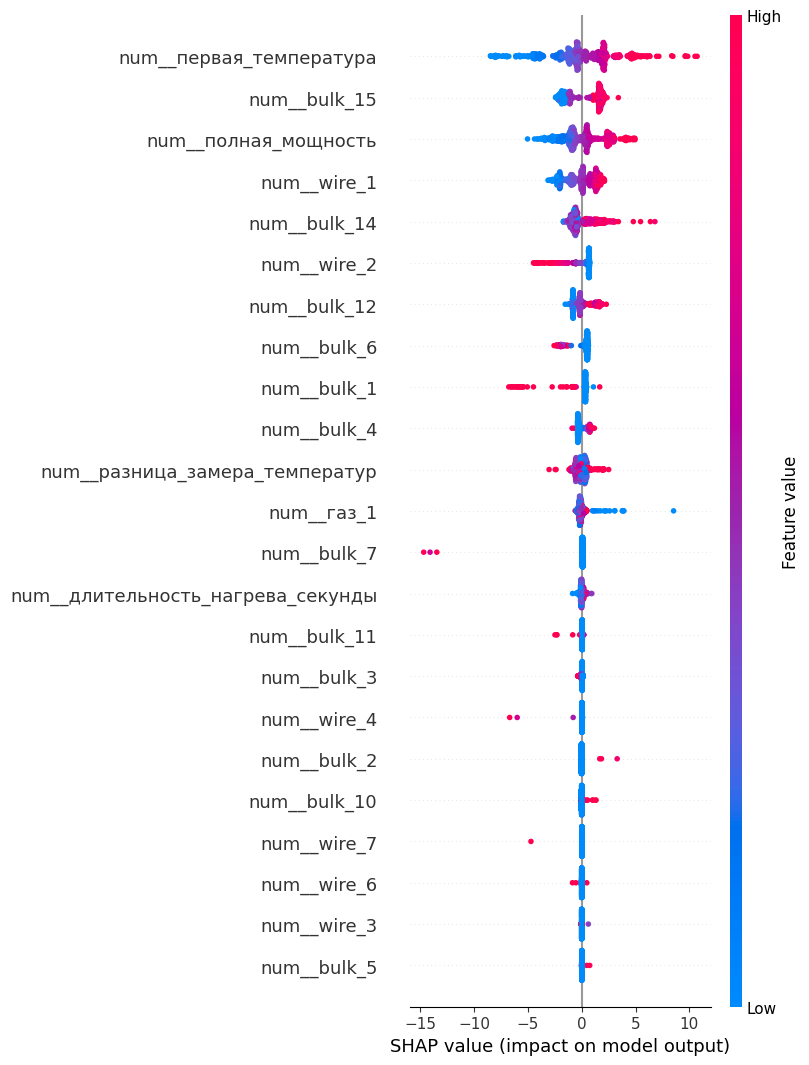

In [41]:
# выведу shap-график важности признаков модели

best_model.fit(X_train, y_train)

X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

preprocessor = best_model.named_steps['preprocessor']
if isinstance(preprocessor, ColumnTransformer):
    feature_names = []
    for transformer_name, transformer, columns in preprocessor.transformers:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(columns))
        else:
            feature_names.extend(columns)
else:
    feature_names = X.columns.tolist()

explainer = shap.TreeExplainer(best_model.named_steps['models'])

shap_values = explainer(X_test_transformed)

shap_values.feature_names = feature_names

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, max_display=len(feature_names))


По графику важности признаков на значение последней температуры сильно влияет первое значение температуры, ряд добавок и полная мощность. Чем больше первое значение температуры, мощнее нагрев и длительность нагрева, тем выше температура. Добавки последовательно изменяют температуру: первая добавка сыпучих материалов понижает температуру, вторая повышает, третья понижает и так далее; первая добавка проволочных материалов повышает температуру, вторая понижает, третья повышает и тд. 

## Точность предсказаний

In [42]:
# проверю точность лучшей модели на dummy_модели 
dummy_regressor = DummyRegressor(strategy='mean')

dummy_regressor.fit(X_train, y_train)

y_pred_dummy = dummy_regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_dummy)

print(f'MAE на Dummy-модели: {mae}')

MAE на Dummy-модели: 7.702302582938532


In [43]:
# проверка точности лучшей модели на тестовых данных
y_pred_final = best_model.predict(X_test)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f'MAE лучшей модели: {mae_final}')
print(f'R2 лучшей модели: {r2_final}')

MAE лучшей модели: 6.564973761060204
R2 лучшей модели: 0.3490368112788951
40:	learn: 10.6362608	total: 76.4ms	remaining: 609ms
41:	learn: 10.6173250	total: 78.3ms	remaining: 607ms
42:	learn: 10.6014940	total: 80.1ms	remaining: 606ms
43:	learn: 10.5866867	total: 82ms	remaining: 604ms
44:	learn: 10.5682276	total: 83.9ms	remaining: 602ms
45:	learn: 10.5507634	total: 85.7ms	remaining: 600ms
46:	learn: 10.5363793	total: 87.7ms	remaining: 599ms
47:	learn: 10.5187587	total: 89.5ms	remaining: 597ms
48:	learn: 10.5018074	total: 92ms	remaining: 599ms
49:	learn: 10.4859442	total: 97.3ms	remaining: 619ms
50:	learn: 10.4728046	total: 99.5ms	remaining: 619ms
51:	learn: 10.4584735	total: 102ms	remaining: 620ms
52:	learn: 10.4448768	total: 107ms	remaining: 634ms
53:	learn: 10.4286557	total: 114ms	remaining: 660ms
54:	learn: 10.4119787	total: 115ms	remaining: 657ms
55:	learn: 10.3968150	total: 117ms	remaining: 654ms
56:	learn: 10.3826912	total: 119ms	remaining: 651ms
57:	learn: 10.3670121	total: 121ms	

## Вывод

### Ход проекта

* Изучила распределение данных
* Предобработала данные: удалила отрицательные мощности, заменила пустые значения в материалах на нули, просуммировала температурные данные по ключу, убрала ключи с температурой ниже 1500 и с одним замером температуры. 
* Объединила таблицы в одну и добавила новые признаки: полную мощность, разницу между временем замера первой и последней температур, длительность нагрева.
* Отобрала признаки: убрала те данные по добавкам, в которых было больше всего пустых значений.
* Проверила данные на мультиколлинеарность. Данные мультиколлинеарны, но обработка не требуется: использую в пайплайне древесную и бустинговые модели.
* Перед прогонкой моделей через RandomisedCV масштабировала признаки, потому что это помогает с улучшением метрики. 
* Лучшая модель - CatBoostRegressor с такими гиперпараметрами: 'preprocessor__num': StandardScaler(), 'models__n_estimators': 324, 'models__max_depth': 3, 'models__learning_rate': 0.05. RANDOM_STATE = 200524.  Модель показывает на тренировочной выборке 6.9 MAE. Значение на Dummy-модели не сильно отличается от значения на тренировочной выборке.
* Проверила важность признаков: по графику важности признаков на значение последней температуры сильно влияет первое значение температуры, ряд добавок и полная мощность. Чем больше первое значение температуры, мощнее нагрев и длительность нагрева, тем выше температура. Добавки последовательно изменяют температуру. 
* Лучшая модель показывает MAE = 6.56 и R2 = 0.34 на тестовой выборке. R2 показывает, в скольких процентах случаев предсказание модели точнее, чем среднее значение целевого признака. Значение R2 такое низкое, потому что использую для предсказаний нелинейные модели. R2 может быть менее полезной в таком случае. MAE больше подходит в этой ситуации.


### Рекомендации бизнесу
* Следить за первой температурой и полной мощностью: чем выше температура и больше полная мощность, тем выше температура финальная.
* Определённые итерации добавок сильнее влияют на температуру. Возможно, за счёт разного объёма добавок. Но в некоторых случаях по добавкам просто больше данных, поэтому это тоже может влиять на важность признака.